# Описание данных и цель проекта


**Цель данного проекта посмотреть как ведут себя модели классификации при нехватке данных. А также проверить возможность применения таких данных для анализа. Данные взяты с Kaggle https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset** 

Age : Возраст пациента

Sex : Пол пациента 
   - 0 = женщина
   - 1 = мужчина

cp : Тип боли в груди
- Value 0: типичная стенокардия
- Value 1: атипичная стенокардия
- Value 2: боль не связанная со стенокардией
- Value 3: бессимптомный 

trtbps : кровяное давление в состоянии покоя (в мм рт. ст.)

chol: уровень холестерина в мг/дл определяется с помощью датчика ИМТ

fbs: (уровень сахара в крови натощак > 120 мг/дл)
- 1 = true
- 0 = false

restecg: результаты электрокардиографии в состоянии покоя
- Value 0: нормальный
- Value 1:наличие аномалии зубца ST-T (инверсии зубца T и/или подъем или понижение ST > 0,05 мВ)
- Value 2: наличие вероятной или определенной гипертрофии левого желудочка по критериям Эстеса

thalach: максимальная частота сердечных сокращений

exang: стенокардия, вызванная физической нагрузкой
- 1 = yes
- 0 = no

old peak: Депрессия ST, вызванная физической нагрузкой по сравнению с отдыхом

slp: наклон сегмента ST пикового упражнения
- 0 = откатывающийся
- 1 = плоский
- 2 = спускающийся по склону

caa: количество крупных сосудов (0-3)

thall : Талассеми́я — это наследственные заболевания крови, для которых характерно снижением выработки гемоглобина.
- 0 = недействительный
- 1 = исправленный дефект
- 2 = нормальный
- 3 = исправимый дефект

output: диагностика заболеваний сердца (ангиографический статус заболевания
- 0: < 50% сужжение диаметра. Меньше шансов заболеть сердечными заболеваниями
- 1: > 50%  сужжение диаметра. Больше шансов заболеть сердечными заболеваниями

# EDA

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt


from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    train_test_split
)
from sklearn.metrics import f1_score, make_scorer


warnings.filterwarnings('ignore')
pd.set_option('display.max_column', None)

RANDOM=42

In [2]:
#Читаем файл
path = 'datasets/heart.csv'
if os.path.exists(path):
    data = pd.read_csv(path)
else:
    print('WRONG PATH')

In [3]:
# Смотрим данные
data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
# Описание данных
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


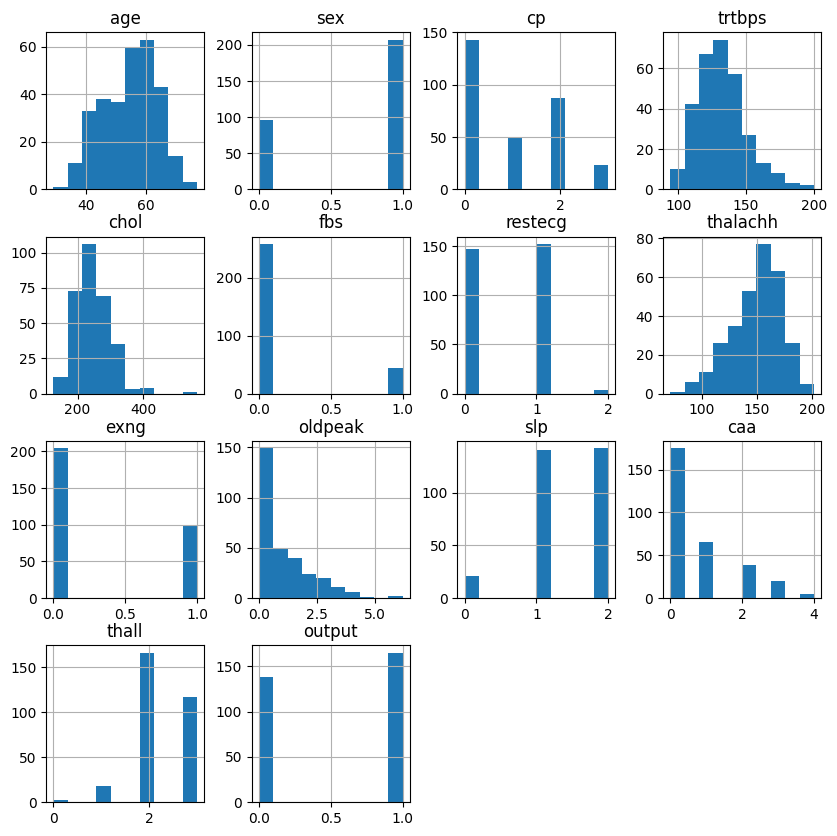

In [5]:
# Посмотрим распределение данных
data.hist(figsize=(10,10));

**Вывод:** Пропущенных значений в данных нет. Типы данных соответсвуют требованиям.

# Исследовательский анализ данных

**Посмотрим влияние возраста, пола и др. признаков на вероятность развития сердечных заболеваний. И на адекватность данных**

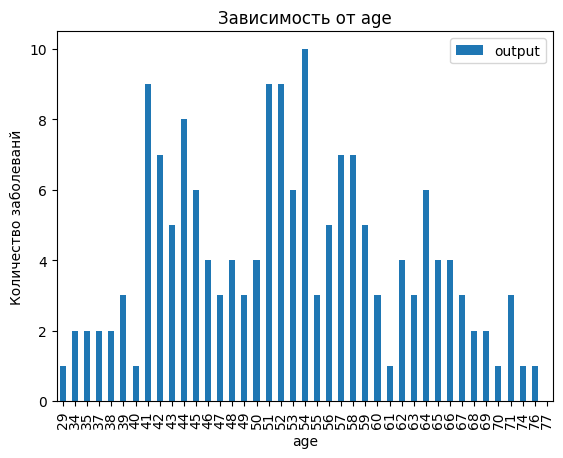

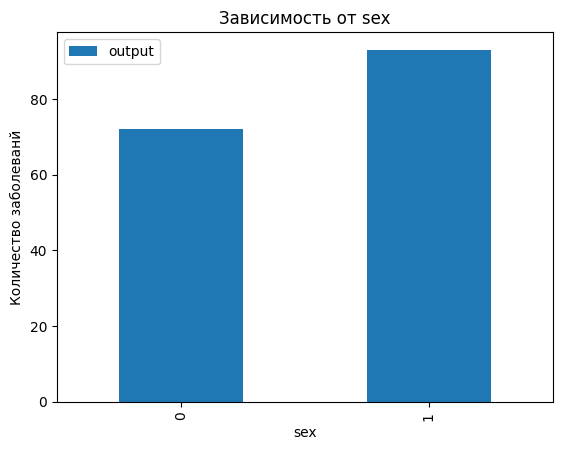

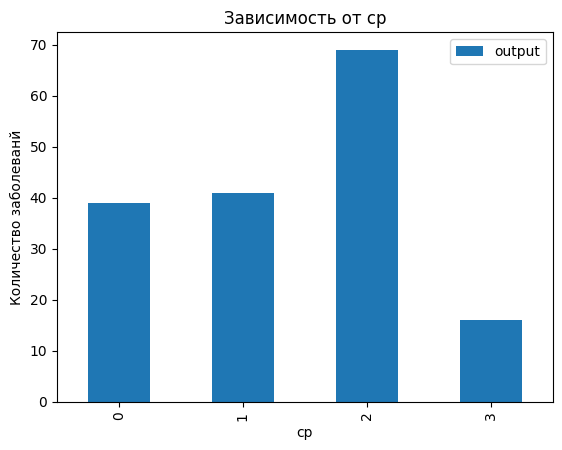

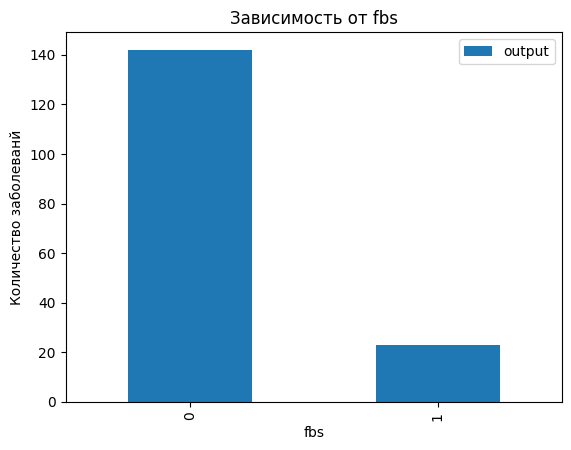

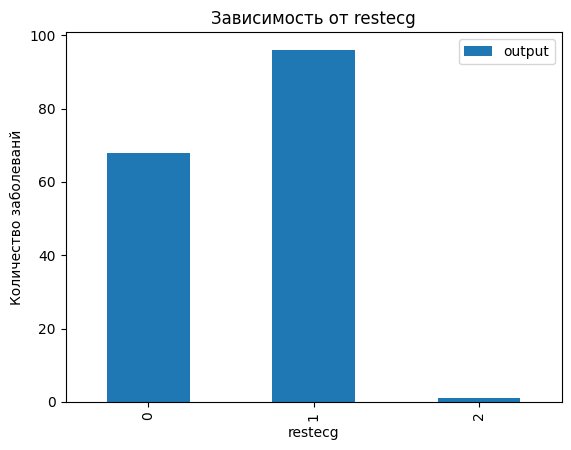

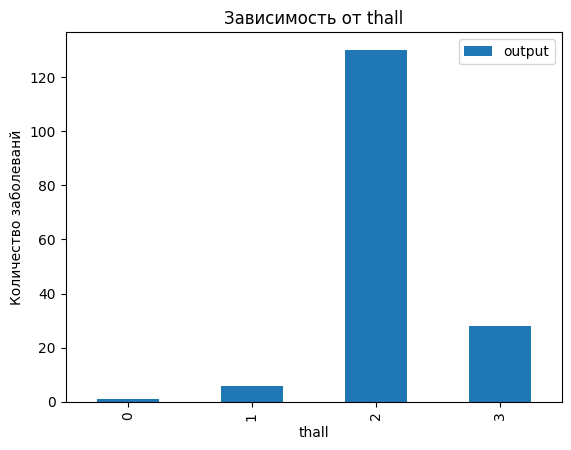

In [6]:
# Построим графики количества сердечных заболеваний по отобранным группам
for i in ['age', 'sex', 'cp', 'fbs', 'restecg', 'thall']:
        df = data.pivot_table(index=i, values='output', aggfunc=(['sum'])).reset_index()
        df.columns = [i, 'output']
        df.plot(kind='bar', x=i, y='output', title=f'Зависимость от {i}')
        plt.ylabel('Количество заболеванй')
        del df;

**Вывод:** На графиках зависимостей вы видим странные занчения. Так например люди с сахарным диабетом имеют меньше шансов получить сердечное заболивание, что расходится с реальным положением дел. На других графиках тоже видны аномалии. 

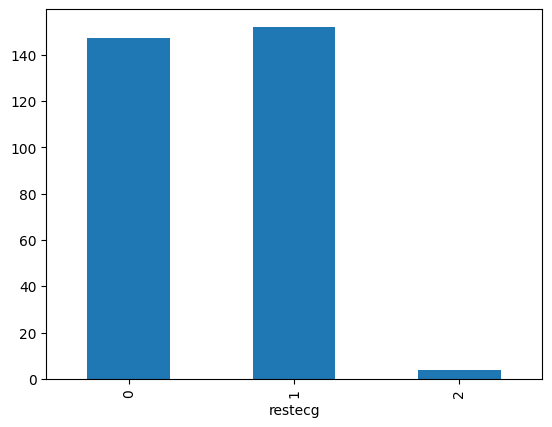

In [7]:
# Посмотрим на баланс групп
data.groupby('restecg')['output'].agg('count').plot(kind='bar');

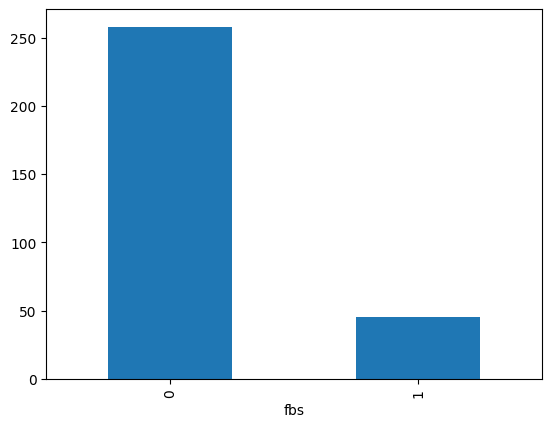

In [8]:
# Посмотрим на баланс групп
data.groupby('fbs')['output'].agg('count').plot(kind='bar');

**Вывод: К недостатку количества данных, добавляется дисбаланс по гркппам с категориальными значениями. Исследование таких данных бессмысленно** 

# Модели для испытаний

**Отбросим релевантность данных, и посмотрим как ведут себя разные классификаторы при нехватке данных.**

In [9]:
# Создадим метрику качества
f1 = make_scorer(f1_score)

In [10]:
# Разобьем данные на обучающую и тестовую выборку
features = data.drop('output', axis=1)
target = data['output']
train_f, test_f, train_t, test_t = train_test_split( features, target, test_size =0.25, random_state=RANDOM)
print(train_f.shape, test_f.shape)

(227, 13) (76, 13)


In [11]:
# Для СatBoost и LGBM обозначим категориальные данные
categorical_features=['sex', 'cp', 'fbs', 'restecg', 'exng','slp', 'caa', 'thall']
train_lgb = train_f.copy()
test_lgb= test_f.copy()
train_lgb[categorical_features] =train_lgb[categorical_features].astype('category')
test_lgb[categorical_features] = test_lgb[categorical_features].astype('category')

## LogisticRegression

In [12]:
# Перебираемые гиперпараметры
grid_space_lr = {
    'max_iter': [100, 200, 500, 1000],                      
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],                                   
}

In [13]:
# # обучающая модель
# lr = LogisticRegression()


# # обучим модель
# grid_lr= GridSearchCV(lr, grid_space_lr,  verbose=1, cv=3, n_jobs=-1, scoring=f1)
# grid_lr.fit(train_f, train_t) 

# print('Best hyperparameters are: '+str(grid_lr.best_params_))
# print('Best score is: '+str(grid_lr.best_score_))

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best hyperparameters are: {'max_iter': 100, 'solver': 'lbfgs'}
    
Best score is: 0.8368733274316472

## RandomForestClassifier

In [14]:
grid_space = {'max_depth': range (1,14, 2),
              'min_samples_leaf': range (1,8),
              'n_estimators':[100, 200, 300, 500] ,
              'criterion':['gini', 'entropy'],
              'max_features': ['sqrt', 'log2']}

In [15]:
# model_rf = RandomForestClassifier(random_state=RANDOM)

# gs_rf = GridSearchCV(
#     model_rf,
#     grid_space,
#     scoring=f1,
#     n_jobs=-1,
#     cv=3
# )

# gs_rf.fit(train_f, train_t)

# print(f'best_score: {gs_rf.best_score_}')
# print(f'best_params: {gs_rf.best_params_}')

best_score: 0.8533358713238792

best_params: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}

## LGBMClassifier

In [16]:
param_dist = {"max_depth": [5, 10, 15, 20],
              "learning_rate" : [0.05, 0.1, 0.15, 0.3],
              "n_estimators": [200, 300, 400, 500],
}

In [ ]:
# lgb = LGBMClassifier(random_state=RANDOM,categorical_feature=categorical_features)

# grid_search = GridSearchCV(lgb, param_dist, cv = 3, 
#                                       verbose=10, n_jobs=-1, scoring=f1)
# grid_search.fit(train_lgb, train_t) 

# print('Best hyperparameters are: '+str(grid_search.best_params_))
# print('Best score is: '+str(grid_search.best_score_))

Fitting 3 folds for each of 192 candidates, totalling 576 fits
 - Best hyperparameters are: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'num_leaves': 32}
 - Best score is: 0.7654779519078821

## CatBoostClassifier

In [18]:
train_data = Pool(data=train_f,
                  label=train_t,
                  cat_features=categorical_features
                 )

In [19]:
test_data = Pool(data=test_f,
                  label=test_t,
                  cat_features=categorical_features
                 )

In [20]:
params = {'cat_features': categorical_features,
              'eval_metric': 'TotalF1',
          'loss_function': 'Logloss',
              'learning_rate': 0.001,
              'random_seed': RANDOM,
              'verbose':200}

In [21]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=3,
    shuffle=True,
    stratified=True,
    verbose=False,
    early_stopping_rounds=20
)

Training on fold [0/3]

bestTest = 0.8833540888
bestIteration = 9

Training on fold [1/3]

bestTest = 0.8536471148
bestIteration = 8

Training on fold [2/3]

bestTest = 0.8091851852
bestIteration = 11



In [22]:
best_value = np.max(cv_data['test-TotalF1-mean'])
print(best_value)

0.8444242539852246


In [28]:
cv_data[cv_data['test-TotalF1-mean'] == 0.8444242539852246]

,iterations,test-TotalF1-mean,test-TotalF1-std,train-TotalF1-mean,train-TotalF1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
8,8,0.844424,0.044152,0.895643,0.02768,0.687916,0.000329,0.687038,0.000837


**Вывод: RandomForest и CatBoost дали лучшие результаты. С учетом среднего отклонения CatBoost имеет больше шансов выдать лучший результат, чем RandomForest. Поэтому будем использовать его.** 

# Испытание на тестовой выборке

In [24]:
model = CatBoostClassifier(**params)
model.fit(train_data)

0:	learn: 0.8502203	total: 14.2ms	remaining: 14.2s
200:	learn: 0.8808892	total: 3.08s	remaining: 12.3s
400:	learn: 0.8895863	total: 6.2s	remaining: 9.26s
600:	learn: 0.8984194	total: 9.19s	remaining: 6.1s
800:	learn: 0.9027746	total: 12.5s	remaining: 3.11s
999:	learn: 0.9071317	total: 15.6s	remaining: 0us


In [25]:
f1_pred= model.predict(test_f)
f1_score(test_t, f1_pred)

0.8837209302325582

In [26]:
model_rf = RandomForestClassifier(criterion='gini', max_depth=5, 
                                   max_features='sqrt', min_samples_leaf=4, 
                                   n_estimators=200, random_state=RANDOM)
model_rf.fit(train_f, train_t)

RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=200,
                       random_state=42)

In [27]:
f1_pred= model_rf.predict(test_f)
f1_score(test_t, f1_pred)

0.8604651162790697

**СatBoost на тестовой выборке получил f1 = 0,883. RandomForest выдал близкий результат f1=0,86. Наш вывод о вероятности получить более точную оценку на СatBoost подтвердился.**

# Итоги


**В ходе исследования были сделаны следующие выводы:**
 - Анализ данных на маленьких датасетах не имеет смысла. Из-за нехватки данных, результаты исследований сильно искаженны.
 - Стандартные модели ML, такие, как RandomForest и LogisticRegression дают близкие результаты к  результатам сложных моделей на основе градиентного бустинга. Таких как Сatboost и LGBM. При этом на примере LGBM мы увидели что сложные модели не всегда дают лучший результат. Иногда лучше использовать стандартные методы. 